# Starbucks Capstone Challenge

## Introduction
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Data Sets

The data is contained in three files:

- portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
- profile.json - demographic data for each customer
- transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

## portfolio.json

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

## profile.json

- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

### transcript.json

- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record


## Business Analysis 

The below there are some business analysis questions:
    
Q. what is the highest number of customer age?

Q. what is majority income of customer?

Q. what is mean income?

Q.which customers are more?

Q.Which was the year of highest number of membership?

Q. Why the male customers are more?

Q.which offer is more popular?

My aim to proceed futher with this starbucks dataset is that to find out above business analysis quetions and build a model that predict if particular offer will responded by the person or not.

if person responded to particular offer then my model will able choose the best offer type.

for that best offer type i will more focus on the bogo and discount.

Anather analysis is that by using different classifier , i will compare the f1_score with test f1_score for each classifier.

In [1]:
#import the required libraries
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
#The below library is used for ignoring the worning if any.
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

### Read Dataset

In [3]:
#read the data set
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


### portfolio dataset

This dataset is very straightforward. It contains the three different offer type. We can see that the duration is not explained in dataset explanation, so we can assume that it is in terms of number of days. 

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


The above head() method result gives the idea about dataset,we can see that first five rows of dataset.

In [5]:
#shape of dataset
portfolio.shape

(10, 6)

In dataset there is only 10 rows and 6 columns,let's move further to analyze each atrribute of dataset

In [6]:
#check unique values of offer_type attribute
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

There is three different offer type which is 'bogo','informational', 'discount'.

### Profile dataset

This is demographic data for customers, it's contains profile of each customer. 

In [7]:
#show the dataset 
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


The first five lines of profile dataset show that there is some null values in gender and income attribute.

In [8]:
#shape of profile dataset
profile.shape

(17000, 5)

There is 17000 rows and 5 columns in the dataset.

In [9]:
#show the some info about profile dataset
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


The above info clearly shows that there is data columns, number of rows and the datatype of each attribute.

In [10]:
#let's get some statistical info about dataset
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


This statistical discribtion of dataset shows the count of rows and the count of all attribute is not same means some missing values are there. 

In [11]:
#check the null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

There is 2175 null values in the gender and income column.

In [12]:
 # age: (numeric) missing value encoded as 118
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

we encoded the missing value as 118.

In [13]:
# drop all missing values
profile.dropna(inplace=True)

here we dropped all null values from dataset

In [14]:
#recheck misssing values
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

see,there is 0 missing values in our dataset so this dataset is ready to procced further.

In [15]:
#check the dataset again after some preprocesssing.
profile.head()

,age,became_member_on,gender,id,income
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


The age value have float datatype , let reconfirm and change it into integer.

In [16]:
#check the datatype of age
profile.age.dtype

dtype('float64')

see, the dtype shows the datatype if age attribute which is float.

In [17]:
#change the datatype of age float to integer.
profile.age=profile.age.astype(int)

This astype metod is convert our float datype into integer.

In [18]:
profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [19]:
# Convert to datetime
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [20]:
#after converting the datetime check the dataset.
profile.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


After converting date into datatime now it's looks in proper format. 

### Data Analysis

#### Q. what is the highest number of customer age?

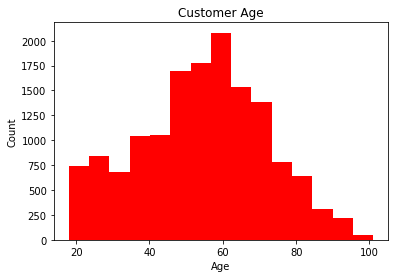

In [21]:
plt.hist(profile['age'], bins = 15, color = 'red');
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Customer Age');

The histogram shows that the clear picture of customer age. The highest number of customers are in between 50 to 60 age.

#### Q. what is majority income of customer?

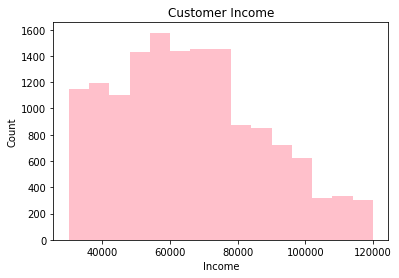

In [22]:
plt.hist(profile['income'], bins = 15, color = 'pink');
plt.xlabel('Income');
plt.ylabel('Count');
plt.title('Customer Income');

We can see that the majority of the income is between 50000-70000 .

#### Q. what is mean income?

In [23]:
profile.income.mean()

65404.991568296799

the above result shows that the mean income of customer is 65404.

#### Q.which customers are more?

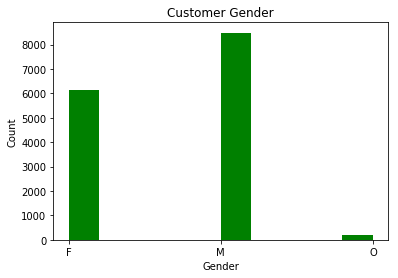

In [24]:
plt.hist(profile['gender'], bins = 10, color = 'green');
plt.xlabel('Gender');
plt.ylabel('Count');
plt.title('Customer Gender');

The above result shows that Males customers are more than female and others.

In [25]:
profile['year'] = profile['became_member_on'].dt.year

In [26]:
profile['year'].count()

14825

#### Q.Which was the year of highest number of membership?

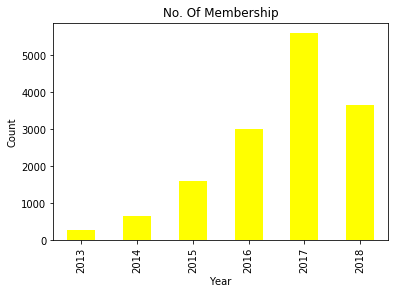

In [27]:
mem_plot =profile.groupby('year').count()['id']
mem_plot.plot(kind = 'bar', color = 'yellow')
plt.title('No. Of Membership')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

The highest number of membership was in 2017

#### Q. Why the male customers are more?

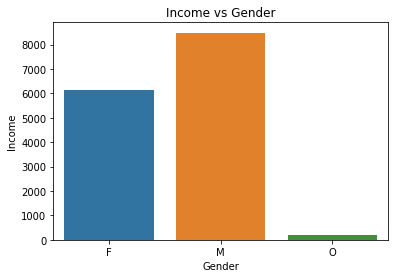

In [28]:
sns.countplot(x=profile[profile['gender'] != 'NA']['gender'])
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

As shown in above result the male customer are more, that maybe beacuse thier income is higher.

#### Q.which offer is more popular?

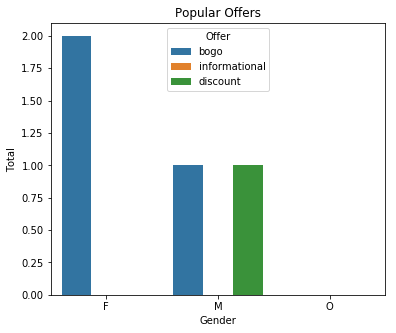

In [29]:
plt.figure(figsize=(6, 5))
sns.countplot(x=profile.gender, hue=portfolio.offer_type)
plt.title('Popular Offers')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();


we can see that bogo offer is more popular  same for both males and females, also discount very popular in male

### Transcript Dataset

This dataset contains the transactional record of each customer.

In [30]:
#let's get familier with this transcript dataset.
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


The event attributes look like it's contains different type of events . let's check that.

In [31]:
#check unique values of event attribute.
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

so there is four type of events which is 'offer received', 'offer viewed', 'transaction', 'offer completed'.

In [32]:
#let's assign this 4 events to different dataframe to processing further.
df1 = transcript[transcript.event == 'transaction']
df2 = transcript[transcript.event == 'offer received']
df3 = transcript[transcript.event == 'offer viewed']
df4 = transcript[transcript.event == 'offer completed']

In [33]:
# add the values of each event to the amount, offer id and reward
df1['amount'] = df1.value.apply(lambda x:list(x.values())[0])
df2['offer_id'] = df2.value.apply(lambda x:list(x.values())[0])
df3['offer_id'] = df3.value.apply(lambda x:list(x.values())[0])
df4['offer_id'] = df4.value.apply(lambda x:list(x.values())[0])
df4['reward'] = df4.value.apply(lambda x:list(x.values())[1])

In [34]:
#cancat the all 4 dataframes into one
transcript = pd.concat([df1,df2,df3,df4])

In [35]:
transcript.head()

,amount,event,offer_id,person,reward,time,value
12654,0.83,transaction,NaN,02c083884c7d45b39cc68e1314fec56c,NaN,0,{'amount': 0.8300000000000001}
12657,34.56,transaction,NaN,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,{'amount': 34.56}
12659,13.23,transaction,NaN,54890f68699049c2a04d415abc25e717,NaN,0,{'amount': 13.23}
12670,19.51,transaction,NaN,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,{'amount': 19.51}
12671,18.97,transaction,NaN,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,{'amount': 18.97}


select the features which is required for model building. 

In [36]:
#select the features
transcript = transcript[['event' , 'person' , 'offer_id' ,'time', 'amount' , 'reward' , 'value']]
transcript.drop(columns='value' , inplace=True)

In [37]:

transcript.head()

,event,person,offer_id,time,amount,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN


The this dataset containd some duplicate values, let's check that.

In [38]:
#check duplicate data into dataset
transcript.duplicated().sum()

397

we can see that there is 397 duplicate values and we are going to drop it.

In [39]:
#drop the duplicate values
transcript.drop_duplicates(inplace=True)

In [40]:
#cross check if any duplicate value is there
transcript.duplicated().sum()

0

Now there is no dulpicate value.

In [41]:
#chech the dataset again 
transcript.head()

,event,person,offer_id,time,amount,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN


In [42]:
#one hot encoding for event
transcript = pd.get_dummies(transcript , columns=['event'] , prefix='' ,prefix_sep='')

created the dummy dataset for events values.

In [43]:
#check the changes in dataset
transcript.head()

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction
12654,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN,0,0,0,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN,0,0,0,1
12659,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN,0,0,0,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN,0,0,0,1
12671,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN,0,0,0,1


we can see that in above dataset the one hot encoding done on event values which is offer completed, offer received, offer viewed and transaction.

In [44]:
#merge the transript and profile dataset.
dataset = pd.merge(transcript , profile ,left_on='person' , right_on='id',how='inner')

To combine the trancript and profile dataset we used left on person ,inner join using id.

In [45]:
#check the merged dataset
dataset.head()

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,id,income,year
0,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN,0,0,0,1,20,2016-07-11,F,02c083884c7d45b39cc68e1314fec56c,30000.0,2016
1,02c083884c7d45b39cc68e1314fec56c,NaN,6,1.44,NaN,0,0,0,1,20,2016-07-11,F,02c083884c7d45b39cc68e1314fec56c,30000.0,2016
2,02c083884c7d45b39cc68e1314fec56c,NaN,12,4.56,NaN,0,0,0,1,20,2016-07-11,F,02c083884c7d45b39cc68e1314fec56c,30000.0,2016
3,02c083884c7d45b39cc68e1314fec56c,NaN,84,1.53,NaN,0,0,0,1,20,2016-07-11,F,02c083884c7d45b39cc68e1314fec56c,30000.0,2016
4,02c083884c7d45b39cc68e1314fec56c,NaN,90,0.50,NaN,0,0,0,1,20,2016-07-11,F,02c083884c7d45b39cc68e1314fec56c,30000.0,2016


In [46]:
#drop the id column
dataset.drop(columns=['id'] , inplace=True)

In [47]:
#let's have look on statistical values of new combined dataset.
dataset.describe()

,time,amount,reward,offer completed,offer received,offer viewed,transaction,age,income,year
count,272388.000000,123957.000000,32070.000000,272388.000000,272388.000000,272388.000000,272388.000000,272388.000000,272388.000000,272388.000000
mean,366.498965,13.996325,4.946367,0.117736,0.244141,0.183048,0.455075,53.838565,64328.153223,2016.457351
std,200.382563,31.749420,2.905766,0.322296,0.429577,0.386706,0.497979,17.551277,21241.306119,1.218782
min,0.000000,0.050000,2.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,2013.000000
25%,186.000000,3.660000,2.000000,0.000000,0.000000,0.000000,0.000000,41.000000,48000.000000,2016.000000
50%,408.000000,10.800000,5.000000,0.000000,0.000000,0.000000,0.000000,55.000000,62000.000000,2017.000000
75%,528.000000,19.130000,5.000000,0.000000,0.000000,0.000000,1.000000,66.000000,78000.000000,2017.000000
max,714.000000,1062.280000,10.000000,1.000000,1.000000,1.000000,1.000000,101.000000,120000.000000,2018.000000


We can see that there is some null values , we are going to handle that.

In [48]:
#fill null values with 0.
dataset.reward.fillna(0 , inplace=True)
dataset.amount.fillna(0 , inplace=True)

In [49]:
#check null values 
dataset.isnull().sum()

person                   0
offer_id            123957
time                     0
amount                   0
reward                   0
offer completed          0
offer received           0
offer viewed             0
transaction              0
age                      0
became_member_on         0
gender                   0
income                   0
year                     0
dtype: int64

There are 123957 null values in offer_id, we are not using offer_id further. so we have to drop this.  

In [50]:
#drop offer_id
dataset.dropna(subset=['offer_id'] ,inplace=True)

In [51]:
#merge the portfolio dataset into new datset.
dataset = dataset.merge(portfolio , left_on='offer_id' , right_on='id'  ,how='left')

In [52]:
#have look on changed dataset
dataset.head()

,person,offer_id,time,amount,reward_x,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income,year,channels,difficulty,duration,id,offer_type,reward_y
0,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0.0,0,1,0,0,20,2016-07-11,F,30000.0,2016,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,02c083884c7d45b39cc68e1314fec56c,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,0.0,0.0,0,1,0,0,20,2016-07-11,F,30000.0,2016,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
2,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0.0,0,0,1,0,20,2016-07-11,F,30000.0,2016,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,0.0,0.0,0,1,0,0,42,2016-01-17,M,96000.0,2016,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
4,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2298d6c36e964ae4a3e7e9706d1fb8c2,336,0.0,0.0,0,1,0,0,42,2016-01-17,M,96000.0,2016,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3


In [53]:
#create data model on person and offer_type 
data_Model = dataset.groupby(['person' , 'offer_type']).agg(
    {
         'offer completed':sum,   
         'offer received': sum, 
         'offer viewed': sum,  
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last'
    }
).reset_index()

created data model on aggrigation of offer completed, offer received, offer viewed, age, become_member_on , gender and income.

In [54]:
#create function to transform offer
def offers_transform(df):
    '''
    Function: to transform the offers
    
    Returns: The transformed offers
    '''
    
    df['bogo_received'] = 0
    df['bogo_completed'] = 0

    df['discount_received'] = 0
    df['discount_completed'] = 0

    for index , row in df.iterrows():
        if(row['offer_type'] == 'bogo'):
            df.loc[index , 'bogo_completed'] = row['offer completed']
            df.loc[index , 'bogo_received'] = row['offer received']

        elif(row['offer_type'] == 'discount'):
            df.loc[index , 'discount_completed'] = row['offer completed']
            df.loc[index , 'discount_received'] = row['offer received']
        
        
        
    return df.groupby(['person']).agg(
    {
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last', 
        'bogo_received':sum,
        'bogo_completed':sum,
        'discount_received':sum,
        'discount_completed':sum,        
    }
).reset_index()

In [55]:
#create new dataset for model building
new_dataset = offers_transform(data_Model)

In [56]:
#have look on new dataset
new_dataset.head()

,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2
1,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2
2,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2
3,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1
4,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,F,73000.0,0,0,3,3


In [57]:
# create colunms with the precnetage of each offer
new_dataset['bogo_perce'] = new_dataset.bogo_completed.div(new_dataset.bogo_received.where(new_dataset.bogo_received != 0, np.nan))*100
new_dataset['discount_perce'] = new_dataset.discount_completed.div(new_dataset.discount_received.where(new_dataset.discount_received != 0, np.nan))*100

In [58]:
#fill the missing values with 0.
new_dataset.fillna(0 , inplace=True)

In [59]:
# check the null values
new_dataset.isna().sum()

person                0
age                   0
became_member_on      0
gender                0
income                0
bogo_received         0
bogo_completed        0
discount_received     0
discount_completed    0
bogo_perce            0
discount_perce        0
dtype: int64

There are no null values in dataset 

In [60]:
#now we can focus on only bogo and discount
new_dataset['bogo_offer'] = 0
new_dataset['discount_offer'] = 0


for i ,row in new_dataset.iterrows():
#focus on bogo and iterated through each value
    if(row['bogo_perce'] >= 80):
        new_dataset.loc[i , 'bogo_offer'] = 1
        
    if(row['discount_perce'] >= 80 ):
        new_dataset.loc[i , 'discount_offer'] = 1

In [61]:
#copy the dataset into new data model to extract year and month from date
data_model2 = new_dataset.copy()
data_model2['year'] = data_model2.became_member_on.dt.year
data_model2['month'] = data_model2.became_member_on.dt.month

In [62]:
#select the features to futher prediction
data_model2 = data_model2[['age' , 'gender' , 'income' ,
                           'year' , 'month' , 'discount_offer' ,
                           'bogo_offer']]

In [63]:
#this is data model 3 where we create the dummy variable of gender
data_model3 = pd.get_dummies(data_model2 , columns=['gender'])

In [64]:
#select the dependent and independent feature for training model
X = data_model3.drop(columns=['discount_offer' ,'bogo_offer'])
y_bogo = data_model3.bogo_offer
y_discount = data_model3.discount_offer

After selecting the feature of X and Y means dependent and independent feature ,we move towords the train, test, split our data.

In [65]:
#train test split our dataset for traning model and making predition.
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(X, y_bogo, random_state=42)
X_train, X_test, y_discount_train, y_discount_test = train_test_split(X, y_discount, random_state=42)

After the rain, test and split we have to choose the some classification algorithm to classify our model.

so we are going to use SVM Classifier.

In [66]:
#use SVM classifier
bogo_svm = SVC()
discount_svm = SVC()
#fit our model
bogo_svm.fit(X_train, y_bogo_train)
discount_svm.fit(X_train, y_discount_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

we can successfully fitted our data into model .

now we are going to calculate f1 score for bogo and discount

In [68]:
#f1_score for bogo
print('Bogo offer F1_score {}'.format( bogo_svm.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(bogo_svm.score(X_test,y_discount_test)))

#f1_score for discount
print('Discount offer Training F1_score {}'.format(discount_svm.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(discount_svm.score(X_test,y_discount_test)))


Bogo offer F1_score 0.6342780026990553
Bogo offe Test F1_score 0.551417004048583
Discount offer Training F1_score 0.8960863697705803
Discount offer Test F1_score 0.5460188933873145


We can see that f1 scores for bogo and discount by using SVM.

next we going to use KNeighborsClassifier

In [69]:
#use KNeighborsClassifier
bogo_model= KNeighborsClassifier()
discount_model = KNeighborsClassifier()
#fit our model
bogo_model.fit(X_train, y_bogo_train)
discount_model.fit(X_train, y_discount_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

see, we can successfully fitted our data into model next we calculating the f1 score for this

we use KNeighborsClassifier to fit our model , now we calculate the F1_score for bogo nad discount

In [72]:
#calculate F1 score for bogo 
print('Bogo offer F1_score {}'.format( bogo_model.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(bogo_model.score(X_test,y_discount_test)))

#f1_score for discount
print('Discount offer Training F1_score {}'.format(discount_model.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(discount_model.score(X_test,y_discount_test)))


Bogo offer F1_score 0.6022492127755286
Bogo offe Test F1_score 0.545748987854251
Discount offer Training F1_score 0.714260008996851
Discount offer Test F1_score 0.5430499325236168


After successsfully implementing the KNeighborsClassifier we are going to use the Gaussian Naive Bayes algorithm

In [73]:
#use Gaussian Naive Bayes algorithm
bogo_G = GaussianNB()
discount_G = GaussianNB()

#fit our model
bogo_G.fit(X_train, y_bogo_train)
discount_G.fit(X_train, y_discount_train)

GaussianNB(priors=None)

After fitting the model we calculate the f1_score for bogo and discount.

In [74]:
#f1_score for bogo
print('Bogo offer F1_score {}'.format( bogo_G.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(bogo_G.score(X_test,y_discount_test)))

#f1_score for discount
print('Discount offer Training F1_score {}'.format(discount_G.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(discount_G.score(X_test,y_discount_test)))


Bogo offer F1_score 0.6021592442645074
Bogo offe Test F1_score 0.5951417004048583
Discount offer Training F1_score 0.6209626630679262
Discount offer Test F1_score 0.6072874493927125


The above result shows the f1 scores of bogo and discount 

next we will apply the Adaboost Classifier to see the changes in f1 score .

In [75]:
#use AdaBoostClassifier
bogo_ada = AdaBoostClassifier()
discount_ada = AdaBoostClassifier()
#fit the data into model
bogo_ada.fit(X_train, y_bogo_train)
discount_ada.fit(X_train, y_discount_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

This is the result of the model fitting by using the adaboost classifier 

now we are going to calculate the f1 score for bogo and discount

In [76]:
#f1_score for bogo
print('Bogo offer F1_score {}'.format( bogo_ada.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(bogo_ada.score(X_test,y_discount_test)))

#f1_score for discount
print('Discount offer Training F1_score {}'.format(discount_ada.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(discount_ada.score(X_test,y_discount_test)))


Bogo offer F1_score 0.6379667116509222
Bogo offe Test F1_score 0.6412955465587045
Discount offer Training F1_score 0.656140350877193
Discount offer Test F1_score 0.6510121457489878


In [77]:
#prediction function for offer
def get_predict(customer , offer):
    '''
    Function: to get the prediction
    
    Input: customer, offer
    
    output: prediction
    
    '''
    predict_bogo = 0
    predict_discount = 0 
     
    #we are make prediction for bogo and discount based on adaboost classifier
    predict_bogo = bogo_ada.predict(customer.values)[0]
    predict_discount = discount_ada.predict(customer.values)[0]
    
    #check the bogo and discount prediction values
    if(predict_bogo == 0 & predict_discount == 0):
        print('No Response!')

     #if the discount is 1 then the discount is prefferred else bogo is prefferd   
    if (offer == 'bogo'):
        if(predict_bogo == 0):
            if(predict_discountt == 1):
                print('preferred discount')           
        else:
            print('Bogo choice')
    if (offer == 'discount'):
        if(predict_discount == 0):
            if(predict_bogo == 1):
                print('preferred bogo')           
        else:
            print('Discount choice')
            #or else discount choice

In [78]:
#get prediction result for bogo 
get_predict(X_test[1:3] ,'bogo')

Bogo choice


we can see that the predicted result is bago choice 

## Conclusion

My aim was that the find out answer of my business analysis questions which was i answerd.
Then anather thing was by processing the data i analysed that the most popular offer type is bogo and discount.
so i mainly focus on that only.

I created model that predicted if the offer will be responded by the particular person or not. if it's responded then my model will choose the best offer type i.e bogo or discount.

By comparing the model i come up with the some conclusion that is:

    a.The highest of all model the SVM model f1_score was 0.89 for discount offer training.
    
    b.the lowest of all models here was KNeighborsClassifier Model by (0.60) for bogo training
    
    c.The company should focus to give more interesting offers to males since their income is higher
    
    d.The bogo and discount increase the customer buying rate. 

